# 6. Recurrent Neural Network (RNN)

Dieses Notebook zeigt, wie man ein spezielles Rekurrentes Neuronales Netz (LSTM) zur Vorhersage von Energieverbrauchsdaten trainieren kann. 
Hierfür werden die Bibliotheken **keras**, sowie **scikit learn** verwendet. <br>
Das Notebook orientiert sich an folgendem Tutorial: https://www.elab2go.de/demo-py5/ (Autoren: Prof. Dr. Eva Maria Kiss, B. Sc. Franc Willy Pouhela, M. Sc. Anke Welz)

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
import math

# matplotlib und seaborn zum Plotten
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn für Überwachtes Lernen
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error

# keras für Neuronale Netze
import tensorflow as tf 
import keras as keras
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout 
from keras.utils import plot_model, model_to_dot
from keras import activations

# Für das Darstellen von Bildern im SVG-Format
import graphviz as gv
import pydot
from IPython.display import SVG

In [5]:
# Daten einlesen
data = pd.read_csv('https://www.elab2go.de/demo-py5/opsd_2016-2019.csv')

In [6]:
data.head()

,Datum,Verbrauch,Wind,Solar,Wind+Solar
0,2016-01-01,1007.11,107.21,18.56,125.77
1,2016-01-02,1147.89,409.62,9.40,419.02
2,2016-01-03,1130.63,406.30,13.52,419.82
3,2016-01-04,1385.93,278.46,10.08,288.54
4,2016-01-05,1430.11,206.47,12.55,219.02


In [7]:
data.tail()

,Datum,Verbrauch,Wind,Solar,Wind+Solar
1456,2019-12-27,1172.20,146.59,20.96,167.55
1457,2019-12-28,1141.33,159.13,36.24,195.36
1458,2019-12-29,1087.07,349.84,54.91,404.75
1459,2019-12-30,1200.05,669.27,53.22,722.49
1460,2019-12-31,1124.93,425.22,36.56,461.79


# Aufgabe 1: Datenvorbereitung
 

* a) Überprüfen Sie, ob in dem Datensatz NaN enthalten sind. Falls ja, überlegen Sie sich, wie Sie damit am besten umgehen.

In [8]:
# Frage 1 a) Überprüfen auf NaN
data.isnull().sum()

# Entfernen der NaN, falls vorhanden
#data = data.dropna(inplace=True, axis=0)

Datum         0
Verbrauch     0
Wind          0
Solar         0
Wind+Solar    0
dtype: int64

*   b) Ist es sinnvoll, mit allen Merkmalen fortzufahren? Was müssen Sie tun um diese Frage beantworten zu können?

In [ ]:
# Frage 1 b)
"""
Es geht um die Vorhersage des Stromverbrauchs, daher gibt es einige irrelevante Merkmale:
Wind, Solar, Wind+Solar

Datum und Verbrauch sind nur für die Prognose relevant, da sie den Zielwert darstellen.
"""

*   c) Bringen Sie die Spalte "Datum" in ein geeignetes Format und indizieren Sie das dataframe mit dieser Spalte 

In [12]:
# Frage 1 c)
data.dtypes

Datum          object
Verbrauch     float64
Wind          float64
Solar         float64
Wind+Solar    float64
dtype: object

Die Spalte `Datum` ist vom Datentyp *Object* und soll im Format *datetime* umgewandelt werden.

In [ ]:
data["Datum"] = pd.to_datetime(data["Datum"])
data.set_index("Datum", inplace=True)

In [24]:
data.head()

,Verbrauch,Wind,Solar,Wind+Solar
Datum,,,,
2016-01-01,1007.11,107.21,18.56,125.77
2016-01-02,1147.89,409.62,9.40,419.02
2016-01-03,1130.63,406.30,13.52,419.82
2016-01-04,1385.93,278.46,10.08,288.54
2016-01-05,1430.11,206.47,12.55,219.02


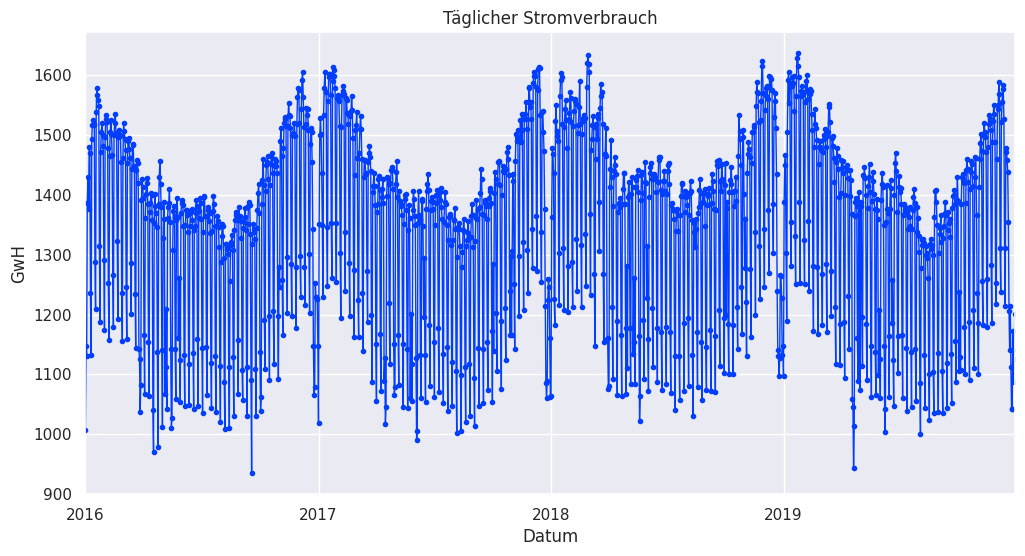

In [32]:
# Plotten des Stromverbrauchs. Der Stromverbrauch soll später mithilfe des Neuronalen Netzes vorhergesagt werden.

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_color_codes('bright')

ax = data['Verbrauch'].plot(linewidth=1, color='b', marker = '.')
ax.set_title('Täglicher Stromverbrauch')
ax.set_xlabel('Datum');
ax.set_ylabel('GwH');

# Aufgabe 2

Im nächsten Codeblock werden *zeitlich versetzte Merkmale* (Lagged Features) mittels der Funktionen `shift()` und `concat()` erzeugt.  

*   a) **Was macht dabei die Funktion [`shift()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) ?** <br> 

    * Die Funktion wird verwendet, um Daten in einer Spalte oder Reihe um eine bestimmte Anzahl von Perioden (Parameter *`periods`*) zu verschieben. <br>
    Zum Beispiel werden die Werte in der Spalte oder Reihe um den angegebenen Wert **nach oben oder unten verschoben.**
    <br> <br>
*   b) **Was macht die Funktion [`concat()`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)?** <br>
    * Die Funktion wird verwendet, um Dataframes entlang einer bestimmten Achse zusammenzuführen. Dadurch können mehrere Dataframes **horizontal oder vertikal verbunden** werden.
    <br> <br>
*   c) **Führen Sie die untenstehende Zelle aus und lassen Sie sich anschließend die ersten 10 Zeilen des neu erzeugten Dataframes ausgeben.**
    <br> <br>
* *Erklärung des untenstehenden Codeblocks:* <br>
    * Es werden die verschobenen `Verbrauch`-Spalten horizontal mit der ursprünglichen `Verbrauch`-Spalte zusammengeführt. Die `shift()`-Funktion wird verwendet, um die Spalte um verschiedene Zeitpunkte zu verschieben. <br> Die resultierenden Spalten werden mit den Bezeichnungen *`t-7` bis `t-1`* versehen, und die ursprüngliche Spalte wird als `Verbrauch` bezeichnet. Alle Zeilen mit fehlenden Werten *(NaN)* werden entfernt.



In [35]:
# Erzeuge zeitlich versetzte Merkmale (lagged features)

consumption = pd.DataFrame(data['Verbrauch'])

data = pd.concat([consumption.shift(7),consumption.shift(6), consumption.shift(5), consumption.shift(4), 
                  consumption.shift(3), consumption.shift(2), consumption.shift(1), data[['Verbrauch']]], axis=1)

data.columns =  ['t-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'Verbrauch']

data.dropna(inplace=True)

In [34]:
data.head(10)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,Verbrauch
Datum,,,,,,,,
2016-01-08,1007.11,1147.89,1130.63,1385.93,1430.11,1375.73,1480.61,1469.35
2016-01-09,1147.89,1130.63,1385.93,1430.11,1375.73,1480.61,1469.35,1236.50
2016-01-10,1130.63,1385.93,1430.11,1375.73,1480.61,1469.35,1236.50,1133.10
2016-01-11,1385.93,1430.11,1375.73,1480.61,1469.35,1236.50,1133.10,1493.80
2016-01-12,1430.11,1375.73,1480.61,1469.35,1236.50,1133.10,1493.80,1517.06
2016-01-13,1375.73,1480.61,1469.35,1236.50,1133.10,1493.80,1517.06,1525.13
2016-01-14,1480.61,1469.35,1236.50,1133.10,1493.80,1517.06,1525.13,1518.12
2016-01-15,1469.35,1236.50,1133.10,1493.80,1517.06,1525.13,1518.12,1515.73
2016-01-16,1236.50,1133.10,1493.80,1517.06,1525.13,1518.12,1515.73,1287.07


*   d) **Hat das Erzeugen der zeitlich versetzten Merkmale erfolgreich funktioniert?**
<br> <br>
    * Ja, es lässt sich eine Verschiebung des Verbrauchs um *`t-1` pro Datum* erkennen.

In [37]:
# Daten in Trainings- und Testset aufspalten

TEST_SPLIT = 0.1 
#data = data.drop(columns = ['Wind', 'Solar'])
train_size = int(len(data) * (1-TEST_SPLIT))
test_size = len(data) - train_size
train = data.iloc[0:train_size]
test = data.iloc[train_size:len(data)]
print("\nTrainingsdaten:") 
print(train.head())
print(train.tail())
print("\nTestdaten:") 
print(test.head())
print(test.tail())


Trainingsdaten:
                t-7      t-6      t-5      t-4      t-3      t-2      t-1  \
Datum                                                                       
2016-01-15  1469.35  1236.50  1133.10  1493.80  1517.06  1525.13  1518.12   
2016-01-16  1236.50  1133.10  1493.80  1517.06  1525.13  1518.12  1515.73   
2016-01-17  1133.10  1493.80  1517.06  1525.13  1518.12  1515.73  1287.07   
2016-01-18  1493.80  1517.06  1525.13  1518.12  1515.73  1287.07  1208.63   
2016-01-19  1517.06  1525.13  1518.12  1515.73  1287.07  1208.63  1537.45   

            Verbrauch  
Datum                  
2016-01-15    1515.73  
2016-01-16    1287.07  
2016-01-17    1208.63  
2016-01-18    1537.45  
2016-01-19    1579.10  
                t-7      t-6      t-5      t-4      t-3      t-2      t-1  \
Datum                                                                       
2019-08-04  1055.72  1337.17  1380.32  1361.27  1330.42  1305.06  1086.43   
2019-08-05  1337.17  1380.32  1361.27  1330.

In [38]:
# Daten auf den Wertebereich [0, 1] skalieren
scaler = MinMaxScaler(feature_range = (0,1))

train_s = scaler.fit_transform(np.array(train))
test_s = scaler.fit_transform(np.array(test))

print("\nTrainingsdaten (unskaliert)\n")
print(train.head(3))
print("\nTrainingsdaten (skaliert)\n")
train_s = pd.DataFrame( train_s , columns = data.columns)
train_s = train_s.set_index(train.index )
print(train_s.head(3))

print("\nTestdaten (unskaliert)\n")
print(test.head(3))
print("\nTestdaten (skaliert)\n")
test_s = pd.DataFrame( test_s , columns = data.columns)
test_s = test_s.set_index(test.index )
print(test_s.head(3))


Trainingsdaten (unskaliert)

                t-7     t-6      t-5      t-4      t-3      t-2      t-1  \
Datum                                                                      
2016-01-15  1469.35  1236.5  1133.10  1493.80  1517.06  1525.13  1518.12   
2016-01-16  1236.50  1133.1  1493.80  1517.06  1525.13  1518.12  1515.73   
2016-01-17  1133.10  1493.8  1517.06  1525.13  1518.12  1515.73  1287.07   

            Verbrauch  
Datum                  
2016-01-15    1515.73  
2016-01-16    1287.07  
2016-01-17    1208.63  

Trainingsdaten (skaliert)

                 t-7       t-6       t-5       t-4       t-3       t-2  \
Datum                                                                    
2016-01-15  0.761870  0.429962  0.282574  0.796722  0.829877  0.841380   
2016-01-16  0.429962  0.282574  0.796722  0.829877  0.841380  0.831388   
2016-01-17  0.282574  0.796722  0.829877  0.841380  0.831388  0.827981   

                 t-1  Verbrauch  
Datum                            
20

In [39]:
# In Merkmale und Label aufteilen
X_train = train_s.drop(columns = ['Verbrauch'])
y_train = pd.DataFrame(train_s['Verbrauch'])

print(X_train.head())
print(y_train.head())

                 t-7       t-6       t-5       t-4       t-3       t-2  \
Datum                                                                    
2016-01-15  0.761870  0.429962  0.282574  0.796722  0.829877  0.841380   
2016-01-16  0.429962  0.282574  0.796722  0.829877  0.841380  0.831388   
2016-01-17  0.282574  0.796722  0.829877  0.841380  0.831388  0.827981   
2016-01-18  0.796722  0.829877  0.841380  0.831388  0.827981  0.502045   
2016-01-19  0.829877  0.841380  0.831388  0.827981  0.502045  0.390236   

                 t-1  
Datum                 
2016-01-15  0.831388  
2016-01-16  0.827981  
2016-01-17  0.502045  
2016-01-18  0.390236  
2016-01-19  0.858941  
            Verbrauch
Datum                
2016-01-15   0.827981
2016-01-16   0.502045
2016-01-17   0.390236
2016-01-18   0.858941
2016-01-19   0.918309


2023-11-26 14:28:59.978213: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-26 14:28:59.978636: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 7, 10)             480       
                                                                 
 lstm_2 (LSTM)               (None, 7, 10)             840       
                                                                 
 lstm_3 (LSTM)               (None, 10)                840       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2171 (8.48 KB)
Trainable params: 2171 (8.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


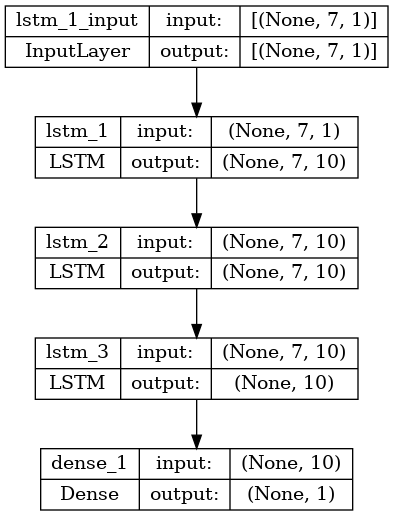

In [40]:
TIMESTEPS = 7 # Länge eines gleitenden Zeitfensters
UNITS = 10 # Ausgabedimension einer einzelnen LSTM-Schicht
N_LAYER = 2 # Anzahl an LSTM-Schichten

# Initialisiere ein sequentielles Modell (Modell mit mehreren Schichten)
model = Sequential(name='sequential') 

#Füge so viele Schichten hinzu, wie in N_LAYER angegeben
for i in range(N_LAYER):

  lstm_layer = LSTM(units = UNITS, # Dimension der Ausgabe
                    input_shape=(TIMESTEPS,1), # Dimension der Eingabe (1. Dimension entspricht Anzahl Zeitschritte, 2. Dimension:  1, da nur ein Merkmal = Verbrauch über die Zeit betrachtet wird (univariates Problem) )
                    return_sequences=True, # wir wollen die gesamte Ausgabesequenz der jeweiligen LSTM-Schicht in die nächste LSTM-Schicht weitergeben können
                    name = 'lstm_' + str(i+1)) # Schichten werden mit "lstm_" + Schichtnummer benannt
                   
  model.add(lstm_layer) # Schicht dem Modell hinzufügen


# weitere LSTM Schicht hinzufügen, bei der nur die letzte Ausgabe (und nicht wie oben die ganze Sequenz) in die nächste Schicht weitergegeben wird
model.add(LSTM(units = UNITS, input_shape=(TIMESTEPS,1), name = 'lstm_' + str(N_LAYER+1)))

# Lineares Layer mit ReLU-Aktivierungsfunktion
model.add(Dense(units = 1, name='dense_1'))#, activation=activations.tanh))

# Konfiguriere das Modell für die Trainingsphase 

# Angeben welcher Optimierer verwendet werden soll
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# über welche Verlustfunktion optimiert werden soll 
# und wie die Performance des Modells gemessen werden soll (hier werden Verlustfunktion und Performancemetrik gleich gewählt, muss aber nicht so sein))
model.compile(optimizer = opt, loss = "mse", metrics=['mean_squared_error'])

# Zusammenfassung und Visualisierung des Modells
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

# Aufgabe 3

* **Welchen Parameter der obigen Codezelle müssten Sie verändern, um 3 LSTM Schichten zu bekommen?** <br>

    * `N_LAYER` soll man auf 3 setzen (`NLAYER = 3`).

# Aufgabe 4

Das Neuronale Netz wird in der unten stehenden Codezelle trainiert. Führen Sie den Code aus. <br>

* **Nach wie vielen Epochen wird das Training auf jeden Fall stoppen?** <br> <br>
    * Das Training wird automatisch gestoppt, wenn der Validierungsverlust (`monitor = 'val_loss'`) für 200 aufeinander folgende Epochen (`patience = 200`) nicht verbessert wird.

*In diesem Fall ist das Training nach 855 Epochen gestoppt worden, heißt nach Epoch 655 gab es keine Verbesserung des Validierungsverlusts.*

In [41]:
# Modell trainieren

# Erstelle Callback für Stop-Kriterium
from keras.callbacks import EarlyStopping, CSVLogger
cb_stop = EarlyStopping(monitor='val_loss', mode='min', 
                        verbose=1, patience=200)
log_file = './data/demo-py5-log.csv'
cb_logger = CSVLogger(log_file, append=False, separator=';')

# X_train erhält eine zusätzliche Dimension und wird dreidimensional
X_train = np.array(X_train)
X_train = np.reshape(X_train, 
                     (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape)

# Trainiere das Modell mit Hilfe der Funktion fit()
BATCH_SIZE = 64
EPOCHS = 1000
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_split=TEST_SPLIT, verbose=2, 
                    callbacks=[cb_logger, cb_stop])

# Speichere das Modell im Format HDF5
model.save("model_adam.h5")

print("History");print(history.history.keys());

(1302, 7, 1)
Epoch 1/1000
19/19 - 3s - loss: 0.0822 - mean_squared_error: 0.0822 - val_loss: 0.0657 - val_mean_squared_error: 0.0657 - 3s/epoch - 184ms/step
Epoch 2/1000
19/19 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - 99ms/epoch - 5ms/step
Epoch 3/1000
19/19 - 0s - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - 88ms/epoch - 5ms/step
Epoch 4/1000
19/19 - 0s - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - 88ms/epoch - 5ms/step
Epoch 5/1000
19/19 - 0s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0518 - val_mean_squared_error: 0.0518 - 87ms/epoch - 5ms/step
Epoch 6/1000
19/19 - 0s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - 82ms/epoch - 4ms/step
Epoch 7/1000
19/19 - 0s - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - 8

/home/chris/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Aufgabe 5

Im untenstehenden Codeblock wird der Trainingsfortschritt geplottet.

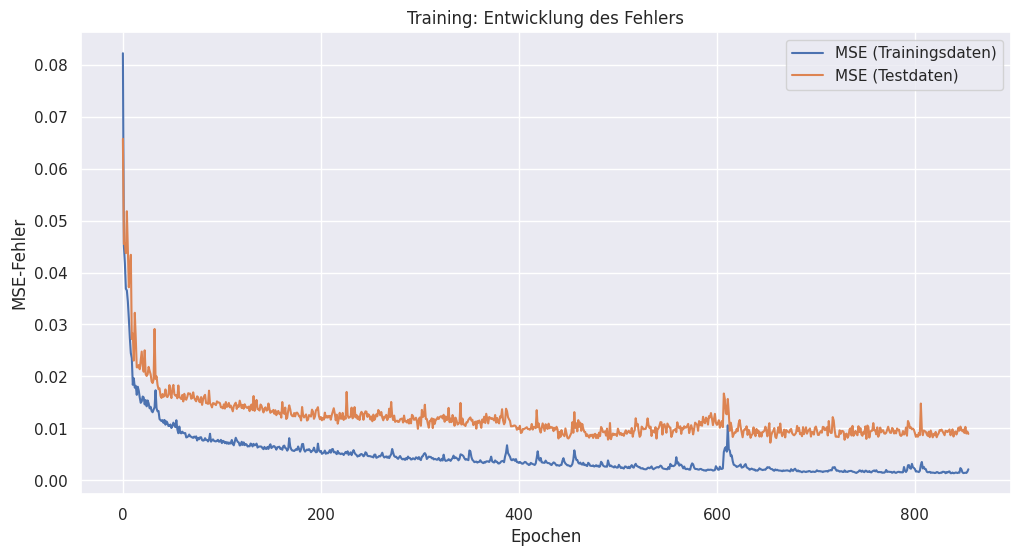

In [42]:
# Trainingsfortschritt plotten

plt.plot(history.history['mean_squared_error'], label='MSE (Trainingsdaten)')
plt.plot(history.history['val_mean_squared_error'], label='MSE (Testdaten)')

plt.title('Training: Entwicklung des Fehlers')
plt.ylabel('MSE-Fehler')
plt.xlabel('Epochen')
plt.legend()

* **Wie beurteilen Sie ihn?** <br> <br>
    * Die Tendenz für `MSE` lautet, dass dies sich im Laufe des Training an `0` nähert. **Je näher der Wert an 0 liegt, desto besser ist das Modell.** <br>
    Mit kleinen Abweichungen nach `600` und `800` wird diese Tendenz behalten, also ist der *Trainingsfortschritt* für die Vorhersage *sehr gut*.

In [43]:
# Testdaten in Merkmale X und Label y aufteilen

X_test = test_s.drop(columns = ['Verbrauch'])
y_test = pd.DataFrame(test_s['Verbrauch'])

# Vorhersage für skalierte Testdaten
X_test = np.array(X_test)
X_test_input = np.reshape(X_test, 
        (X_test.shape[0], X_test.shape[1], 1))

y_test = np.array(y_test)
#y_test = np.reshape(y_test, 
        # (y_test.shape[0],  1))
y_pred = model.predict(X_test_input)

pred = np.concatenate((X_test, y_pred), axis=1)

# Reskaliere die Daten
test_rs = pd.DataFrame(scaler.inverse_transform(test_s), columns = test_s.columns)
pred_rs = pd.DataFrame(scaler.inverse_transform(pred), columns = test_s.columns)

y_test = test_rs['Verbrauch']
y_pred = pred_rs['Verbrauch']

# Berechne RMSE der Validierungsdaten
mse = mean_squared_error(y_test, y_pred)
rmse = np.round(np.sqrt(mse))
print("Validierungs-Fehler:")
print("\nMSE:\n %.2lf" % (mse))

5/5 [==============================] - 1s 2ms/step
Validierungs-Fehler:

MSE:
 4802.80


In [44]:
def rel_error(df, col1, col2):
    df['Error (%)'] = (df[col1] - df[col2]) / df[col1]  * 100
    df['Error (%)'] = df['Error (%)'].abs()
    return df['Error (%)']

In [45]:
# Hilfsfunktion error_table erzeugt Fehlertabelle
def error_table(df1, df2, col1, col2, idx):
    cols = [df1, df2]
    headers = [col1, col2]
    # Erzeuge pred aus y_test und y_pred mit Index idx
    pred = pd.concat(cols, axis=1, keys=headers) 
    pred.set_index(idx, inplace=True)
    # Füge Fehler-Spalten hinzu
    pred['Error'] = np.abs(pred['y_test'] - pred['y_pred'])
    pred['Error(%)'] = rel_error(pred, 'y_test', 'y_pred')
    pred = pred.astype(float).round(1)
    # Füge RMSE hinzu
    mse = mean_squared_error(df1, df2)
    rmse = np.round(np.sqrt(mse))
    pred.index.name = "RMSE: " + str(rmse)
    return pred

# Erzeuge Fehlertabelle für Validierung und gebe sie aus
idx = test.index;
pred = error_table(pd.DataFrame(y_test), pd.DataFrame(y_pred), 'y_test', 'y_pred', idx)

pred.head()

,y_test,y_pred,Error,Error (%),Error(%)
,Verbrauch,Verbrauch,,,
RMSE: 69.0,,,,,
2019-08-09,1318.8,1314.8,3.9,0.3,0.3
2019-08-10,1132.4,1163.6,31.2,2.8,2.8
2019-08-11,1043.5,1090.4,47.0,4.5,4.5
2019-08-12,1299.0,1301.7,2.7,0.2,0.2
2019-08-13,1313.7,1300.5,13.2,1.0,1.0


In [55]:
error_min = pred['Error (%)'].min()
error_max = pred['Error (%)'].max()
error_mean = pred['Error (%)'].mean()

print("Fehlerrate (in %):")
print("Min: %.2lf" % (error_min))
print("Max: %.2lf" % (error_max))
print("Average: %.2lf" % (error_mean))

Fehlerrate (in %):
Min: 0.00
Max: 30.10
Average: 3.63


In [49]:
sorted_pred = pred.sort_values(by=['Error (%)'], ascending=False)
sorted_pred.head(10)

,y_test,y_pred,Error,Error (%),Error(%)
,Verbrauch,Verbrauch,,,
RMSE: 69.0,,,,,
2019-12-25,1042.2,1356.5,314.2,30.1,30.1
2019-11-03,1101.1,1378.4,277.3,25.2,25.2
2019-12-26,1042.7,1275.6,232.9,22.3,22.3
2019-10-03,1105.3,1284.5,179.2,16.2,16.2
2019-10-06,1107.8,1287.2,179.4,16.2,16.2
2019-11-01,1235.5,1050.2,185.3,15.0,15.0
2019-09-28,1155.8,1301.6,145.7,12.6,12.6
2019-10-28,1429.8,1263.0,166.8,11.7,11.7


#### Mit einer *maximalen Fehlerrate von 30.1 %* und *Mittelwert von 3.63 %* kann man behaupten, dass das Vorhersagemodell zwar gut ist, aber **wenig bis keine industrielle Anwendung** finden kann.